# ySKILLS Data Preprocessing

This Markdown file is a guide to the data preprocessing steps that were taken to prepare the data for the Logistic Regression exercise.

The original source of the data is Data in Brief Vol. 54 article [Digital skills among youth: A dataset from a three-wave longitudinal survey in six European countries](https://www.sciencedirect.com/science/article/pii/S2352340924003652). The CSV data is around 33 MB and contains 800+ columns. Since this is a beginner's course, I have chosen to prepare the data for you. 

You can download the data and do your own analysis, or, you can choose to use the prepared data created using this notebook. Do keep in mind that you will be able to increase the model' accuracy by doing your own data preprocessing and feature engineering. The data preprocessing I can chosen to perform makes some assumptions and simplifications that may not be the best for the model. The key assumption is that the derived features are the most important features for the model. If you do decide to do your own data preprocessing, you will also need the data dictionary that is an Excel file. All these files can be found by following the link above.

Our chosen research problem is: **Can we predict the RISK101 variable using the other variables in the dataset?**

The RISK101 is defined as: **Experience with cyberhate in the PAST YEAR**

Longer description from dictionary Excel: *ON THE INTERNET, you may encounter content that attacks certain groups or individuals (e.g., because of their skin colour, religion, nationality, gender, or sexuality). This could be, for example, Muslims, migrants, Jews, Roma, etc. [USE LOCAL EXAMPLES]. This could be in the form of hateful, degrading, or racist messages, comments, images, or videos.*

In [62]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Load the original 33 MB CSV


In [63]:
file_path = "ySKILLS_longitudinal_dataset.csv"
df = pd.read_csv(file_path, encoding="latin1", delimiter=";", low_memory=False)

## Merge Waves

Many of the columns exist three times, since the same questionnaire has been performed three times. These are waves 1, 2 and 3.

The columns are named with the wave number as a suffix. Example: `W1_something`, `W2_something`, `W3_something`.

However, the `len(df.columns)` is not divisible by 3, so there are some columns that are expection. Let's find them.


In [64]:
# Extract column names
column_names = df.columns
assert len(column_names) == len(set(column_names)), "Column names are not unique"

# W#_<something> pattern
pattern = re.compile(r"W[1-3]_(.+)")
matching_columns = [col for col in column_names if pattern.match(col)]
non_matching_columns = [col for col in column_names if not pattern.match(col)]

# Step 2: Identify the unique base names and check their presence across W1, W2, W3
column_identifiers = {}
for col in matching_columns:
    wave = col[:2]  # W#
    identifier = pattern.findall(col)[0]  # <something>

    if identifier not in column_identifiers:
        column_identifiers[identifier] = set()
    column_identifiers[identifier].add(wave)

# Identify all that have all 3 waves
omni_wave_columns = [
    base for base, waves in column_identifiers.items() if len(waves) == 3
]
missing_wave_columns = [
    base for base, waves in column_identifiers.items() if len(waves) != 3
]

print(
    "The columns that do not match to W#_<something> pattern are:", non_matching_columns
)
print("The columns that do not exist in all 3 waves are:", missing_wave_columns)

The columns that do not match to W#_<something> pattern are: ['country', 'waves']
The columns that do not exist in all 3 waves are: ['ETHN_6_DE']


## Concanate the three waves into rows

We will keep the "country" column as it might work as a feature for the model.

Original data was in wide format. Each student has only one row, and there are columns for each wave. Example:

| country | W1_egg | W1_ham | W2_egg | W2_ham | W3_egg | W3_ham |
|---------|--------|--------|--------|--------|--------|--------|
| 1       | 1      | 2      | 3      | 4      | 5      | 6      |
| 2       | 7      | 8      | 9      | 10     | 11     | 12     |

After the next cell, the data will be in tall format:

| country | egg | ham |
|---------|-----|-----|
| 1       | 1   | 2   |
| 1       | 3   | 4   |
| 1       | 5   | 6   |
| 2       | 7   | 8   |
| 2       | 9   | 10  |
| 2       | 11  | 12  |

In [65]:
# Drop hand-picked columns
unwanted_columns = [
    "country"
] # The country would end up being a dulicate column

filtered_columns = [col for col in omni_wave_columns if col not in unwanted_columns]

# Step 1: Load columns ["country"] + ["W1_" + x for x in all_waves]
df_1 = df[["country"] + ["W1_" + col for col in filtered_columns]]
df_2 = df[["country"] + ["W2_" + col for col in filtered_columns]]
df_3 = df[["country"] + ["W3_" + col for col in filtered_columns]]

# Step 2: Rename the columns to not have the prefix
df_1.columns = ["country"] + filtered_columns
df_2.columns = ["country"] + filtered_columns
df_3.columns = ["country"] + filtered_columns

# Step 3: Concatenate the DataFrames
df_long = pd.concat([df_1, df_2, df_3], ignore_index=True)

## Keep only rows with existing target value

The negative numbers mean that the data is not available for some reason. For example, `-94` means that _"Not asked"_.


In [66]:
mask = df_long["RISK101"] < 0
df_observations = df_long[~mask]

## Process Strings to Numbers

Some of the numerical values are encoded as string `",123"` instead of a number like `0.123`. The missing leading zero is not something we would expect from a CSV file. Let's fix this.

Also, some of these columns include a string `" "` (whitespace). Let's make these `-42`s. 

Why `-42`? It is our own convention for missing values, following the ySKILLS's convention. All negatives numbers will be dropped later.


In [67]:
problematic_columns = [
    "friends",
    "family",
    "civic",
    "effi",
    "sati_pos",
    "sati_neg",
    "sensa",
    "restrict",
    "enabling",
    "skill_tech_pro",
    "skill_inf_pro",
    "skill_cont_pro",
    "skill_know_pro",
    "skill_comm_pro",
    "skill_overall_pro",
    "lit_overall_pro",
    "kninf",
    "kncomm",
    "kncont",
    "lit_comm_pro",
    "lit_cont_pro",
    "lit_inf_pro",
]

for col in problematic_columns:
    df_observations.loc[:, col] = (
        (
            df_observations[col]
            .str
            .replace(",", ".")
            .replace(" ", "-42")
            .apply(pd.to_numeric)
        )
    )

# Cherry Pick Derived Columns

Instead of using the original columns, let's use the derived columns. The reasoning to this was explained in the first cell of this Notebook.

However, some of these columns overlap a lot. We want to avoid having two columns explaining the same thing (multicollinearity). This information has been provided by ySKILLS data dictionary Excel. Below is a summarization of the columns to keep and remove.


**Summary of Columns to Retain and Remove:**

Retain:

* friends: Mean value from FRIEND1a, FRIEND1b, FRIEND1c.
* family: Mean value from FAM1a, FAM1b, FAM1c.
* civic: Mean value from CIV1a, CIV1b, CIV1c, CIV1d, CIV1e.
* daily_activities: Number of daily online activities, from ACT1a to ACT1k.
* effi: Mean value from EFFI1a, EFFI1b, EFFI1c, EFFI1d.
* sati_pos: Mean value from SATI1a, SATI1b, SATI1c.
* sati_neg: Mean value from SATI1d, SATI1e, SATI1f.
* sensa: Mean value from SENS1a, SENS1b, SENS1c, SENS1d.
* restrict: Mean value from MED1a, MED1b, MED1c.
* enabling: Mean value from MED2a, MED2b, MED2c, MED2d.
* skill_tech_pro: Proportion of skills at a high level, from W1_SKILL1a to W1_SKILL1f.
* skill_progr: Programming skills, from W1_SKILL1g.
* lit_inf_pro: Proportion of skills and knowledge items at a high level, from W1_SKILL2a to W1_SKILL2f and W1_SKILL5a_correct.
* lit_comm_pro: Proportion of skills and knowledge items at a high level, from W1_SKILL2a to W1_SKILL2f and W1_SKILL5a_correct.
* lit_cont_pro: Proportion of skills and knowledge items at a high level, from W1_SKILL4a to W1_SKILL4f and W1_SKILL5e_correct.
* skill_know_pro: Proportion of correct answers, from W1_SKILL5a_correct to W1_SKILL5f_correct.
* lit_overall_pro: Proportion of skills at a high level, including programming and overall knowledge, with no more than 2 missing on any skill subscale or the overall knowledge scale.

Remove:

* skill_inf_pro: Covered by lit_inf_pro.
* skill_comm_pro: Covered by lit_comm_pro.
* skill_cont_pro: Covered by lit_cont_pro.
* skill_overall_pro: Covered by lit_overall_pro.
* civic_dich: Covered by civic.

In [68]:
basic_info_columns = [
    "country",
    "Age_year",
    "GENDER",
]

derivated_columns = [
    "friends",
    "family",
    "civic",
    # "civic_dich",        # Skipped due to reasons explained in the cell above
    "daily_activities",
    "effi",
    "sati_pos",
    "sati_neg",
    "sensa",
    "restrict",
    "enabling",
    "skill_tech_pro",
    "skill_progr",
    # "skill_inf_pro",     # ... same
    "lit_inf_pro",
    # "skill_comm_pro",    # ... same
    "lit_comm_pro",
    # "skill_cont_pro",    # ... same
    "lit_cont_pro",
    "kninf",
    "kncomm",
    "kncont",
    "skill_know_pro",
    # "skill_overall_pro", # ... same
    "lit_overall_pro",
]

target_column = ["RISK101"]

df_cherry_picked = df_observations[basic_info_columns + derivated_columns + target_column]

## Investigate Column Values

Let's check out the unique values of the columns. The information here should be also accessible from the ySKILLS data dictionary Excel or the website. For example, the column sati_pos should have values from 1 to 4. This can be verified from the website, which states that: "W#_sati_pos (scale 1–4); W#_sati_neg (scale 1–4)"

In [69]:
# Create a DataFrame that shows all the unique values per column. Row should be a column, and the values should be a set of unique values in that column.
unique_values = df_cherry_picked.map(lambda x: round(x, 2)).apply(lambda x: set(x.unique()), axis=0)

# Display it as a DataFrame
unique_values_df = pd.DataFrame(unique_values, columns=["unique_values"])

# Round all values to precision of 2
unique_values_df = unique_values_df

# Add a column that displays the count of unique values in the column unique_values
unique_values_df["n_unique"] = unique_values_df["unique_values"].apply(len)
unique_values_df["n_uniq_non_neg"] = unique_values_df["unique_values"].apply(lambda x: len([v for v in x if v >= 0]))
unique_values_df["min"] = df_cherry_picked.min()
unique_values_df["min_non_neg"] = df_cherry_picked[df_cherry_picked >= 0].min()
unique_values_df["max"] = df_cherry_picked.max()
unique_values_df["percent_missing"] = (df_cherry_picked[df_cherry_picked < 0].count() / df_cherry_picked.count() * 100).round(2)

unique_values_df

,unique_values,n_unique,n_uniq_non_neg,min,min_non_neg,max,percent_missing
country,"{616, 233, 620, 276, 246, 380}",6,6,233,233,620,0.00
Age_year,"{10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",14,13,-99,10.0,22,0.12
GENDER,"{0, 1, 2, -99}",4,3,-99,0.0,2,0.01
friends,"{1.67, 2.67, 3.67, 3.0, 3.33, 4.0, 2.33, 2.0, ...",11,10,-99.0,1.0,4.0,11.29
family,"{1.67, 2.67, 3.0, 3.67, 4.0, 2.33, 3.33, 1.33,...",11,10,-99.0,1.0,4.0,8.75
civic,"{1.4, 2.4, 1.6, 4.0, 1.25, 3.4, 3.25, 2.6, 2.2...",32,31,-99.0,1.0,4.0,4.42
daily_activities,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -99}",13,12,-99,0.0,11,4.58
effi,"{1.67, 2.0, 2.5, 3.5, 3.25, 3.0, 4.0, 2.33, 3....",20,19,-99.0,1.0,4.0,7.65
sati_pos,"{1.67, 2.67, 3.33, 4.0, 1.0, 3.67, 2.0, 2.33, ...",11,10,-99.0,1.0,4.0,9.03
sati_neg,"{1.67, 2.67, 3.33, 1.33, 3.0, 4.0, 2.33, 2.0, ...",11,10,-99.0,1.0,4.0,9.93


# Impute missing values

All negative values are treated as missing. We will impute these with the `mode` ("most frequent") of the column.

For better results, you might want to use `mean` for numerical columns and `mode` for categorical columns. However, for this exercise, we will use `mode` for all columns.

In [70]:
# Convert all negative numbers to NaN
df_cherry_picked = df_cherry_picked.map(lambda x: np.nan if x < 0 else x)

imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_cherry_picked), columns=df_cherry_picked.columns)

df_imputed

,country,Age_year,GENDER,friends,family,civic,daily_activities,effi,sati_pos,sati_neg,...,skill_progr,lit_inf_pro,lit_comm_pro,lit_cont_pro,kninf,kncomm,kncont,skill_know_pro,lit_overall_pro,RISK101
0,620.0,18.0,0.0,4.000000,3.666667,1.40,6.0,2.500000,3.333333,1.666667,...,0.0,0.125,0.875,0.750000,1.0,1.0,2.0,0.666667,0.580645,1.0
1,620.0,16.0,1.0,4.000000,3.000000,1.25,3.0,1.666667,3.333333,3.000000,...,0.0,0.250,0.750,0.125000,2.0,2.0,1.0,0.833333,0.387097,1.0
2,620.0,16.0,0.0,3.333333,4.000000,1.60,7.0,3.500000,4.000000,1.333333,...,0.0,0.875,0.500,0.625000,1.0,0.0,1.0,0.333333,0.709677,0.0
3,620.0,16.0,0.0,3.333333,3.666667,1.60,2.0,2.000000,4.000000,2.666667,...,0.0,0.375,0.500,0.125000,2.0,0.0,1.0,0.500000,0.451613,1.0
4,620.0,16.0,1.0,3.666667,3.666667,4.00,9.0,3.250000,2.666667,3.333333,...,0.0,0.750,0.750,0.750000,1.0,1.0,2.0,0.666667,0.677419,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12408,620.0,18.0,1.0,3.000000,2.666667,1.00,6.0,2.500000,4.000000,3.000000,...,0.0,0.500,0.750,0.250000,0.0,2.0,1.0,0.500000,0.548387,1.0
12409,620.0,18.0,0.0,4.000000,4.000000,2.00,5.0,3.750000,3.666667,3.333333,...,0.0,0.750,0.875,0.428571,2.0,1.0,2.0,0.833333,0.566667,1.0
12410,620.0,18.0,0.0,3.000000,3.000000,2.20,7.0,4.000000,4.000000,2.333333,...,0.0,0.625,0.875,0.500000,1.0,1.0,2.0,0.666667,0.709677,1.0
12411,620.0,18.0,1.0,3.333333,3.666667,3.40,5.0,3.250000,4.000000,2.666667,...,0.0,0.250,0.500,0.375000,2.0,2.0,2.0,1.000000,0.451613,1.0


## Check Correlations

Let's plot the correlations so that we will have some idea of which columns are correlated with the target variable.

You could also plot the correlation matrix, but due to large number of columns, it would be hard to read without any filtering.

We will simply check the correlations between the target variable and the features.

<Axes: >

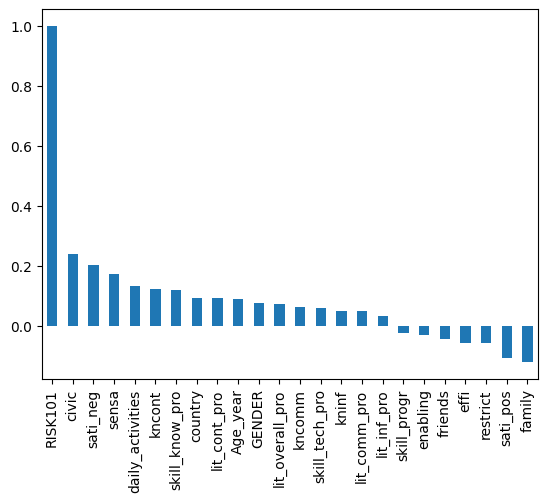

In [71]:
# Correlation between RISK101 and other columns
correlations = df_imputed.corr()["RISK101"].sort_values(ascending=False)
correlations.plot(kind="bar")

## Perform Standardization and One Hot Encoding

Data is as follows:

| column           | n_unique | min   | max   |
|------------------|----------|-------|-------|
| country          | 6        | 233.0 | 620.0 |
| Age_year         | 13       | 10.0  | 22.0  |
| GENDER           | 3        | 0.0   | 2.0   |
| friends          | 10       | 1.0   | 4.0   |
| family           | 10       | 1.0   | 4.0   |
| civic            | 31       | 1.0   | 4.0   |
| daily_activities | 12       | 0.0   | 11.0  |
| effi             | 19       | 1.0   | 4.0   |
| sati_pos         | 10       | 1.0   | 4.0   |
| sati_neg         | 10       | 1.0   | 4.0   |
| sensa            | 25       | 1.0   | 5.0   |
| restrict         | 13       | 1.0   | 5.0   |
| enabling         | 25       | 1.0   | 5.0   |
| skill_tech_pro   | 13       | 0.0   | 1.0   |
| skill_progr      | 2        | 0.0   | 1.0   |
| lit_inf_pro      | 22       | 0.0   | 1.0   |
| lit_comm_pro     | 23       | 0.0   | 1.0   |
| lit_cont_pro     | 22       | 0.0   | 1.0   |
| kninf            | 3        | 0.0   | 2.0   |
| kncomm           | 3        | 0.0   | 2.0   |
| kncont           | 3        | 0.0   | 2.0   |
| skill_know_pro   | 13       | 0.0   | 1.0   |
| lit_overall_pro  | 89       | 0.0   | 1.0   |
| RISK101          | 2        | 0.0   | 1.0   |

We need to choose how we will encode the categorical columns and how we will standardize the numerical columns. We will use `StandardScaler` for numerical columns and `OneHotEncoder` for categorical columns.

The binary columns are already in the correct format. We will not touch them.

In [72]:
# These will be one-hot encoded
CATEGORICAL = [
    "country",
    "Age_year",
    "GENDER",
]

# These will be scaled
ORDINAL = [
    "friends",
    "family",
    "civic",
    "daily_activities",
    "effi",
    "sati_pos",
    "sati_neg",
    "sensa",
    "restrict",
    "enabling",
    "skill_tech_pro",
    "lit_inf_pro",
    "lit_comm_pro",
    "lit_cont_pro",
    "kninf",
    "kncomm",
    "kncont",
    "skill_know_pro",
    "lit_overall_pro",
]

# The binary columns will be left as they are
BINARY = [
    "skill_progr",
    "RISK101",  # This is our target, the y
]


# Init processors
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
ordinal_scaler = StandardScaler()

categorical_encoded = one_hot_encoder.fit_transform(df_imputed[CATEGORICAL])
ordinal_scaled = ordinal_scaler.fit_transform(df_imputed[ORDINAL])

# The one-hot encoding returns a numpy array, so we need to convert it back to a DataFrame
# Note that it will contain more columns than the original categorical columns
df_scaled = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(CATEGORICAL))

# Replace the original columns with the processed ones
df_scaled[ORDINAL] = ordinal_scaled
df_scaled[BINARY] = df_imputed[BINARY]


## Export the dataset as CSV

In [73]:
df_scaled.to_csv("../../data/y_skills/ySKILLS_longitudinal_dataset_teacher_processed.csv", index=False)

# Train Logistic Regression

Using the LogisticRegression from sklearn, you should now be able to train the model and get results such as:

```
          Predicted 0  Predicted 1
Actual 0          297          740
Actual 1          175         2512
````

Note that the precise values will depend on the chosen parameter values and e.g. the random seed.

The accuracy should reach about `0.75`.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Split the dataset into features (X) and target variable (y)
X = df_scaled.drop('RISK101', axis=1)
y = df_scaled['RISK101']

############### CENSORED ###############
# This has been cut out.               #
# Figure it out in your own Notebook.  #
#                                      #
#               :)                     #
############### CENSORED ###############

## Compare to Random Chance

How well does our model perform against random chance? Or simply guessing the most common value? 

One way to check this is using RO-curve and Area Under the Curve (AUC). If AUC is above 0.5, the model is better than random chance. 

P.S. If it is below 0.5, we have our 1 and 0 mixed up.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model = None # You should have this from the cell above
X_test = ... # ... same as above
y_test = ... # ... same as above

# Create true and false positive rates
y_hat = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("The AUC is: ", roc_auc_score(y_test, y_hat))